# Введение

Модели обнаружения объектов можно разделить на «одноэтапные» и «двухэтапные» детекторы. Двухэтапные детекторы часто более точны, но обладают медленной производительностью. В данном ноутбуке мы рассмотрим и реализуем RetinaNet, популярный одноэтапный детектор, который работает быстро и при этом достаточно точно. RetinaNet использует пирамидальную сеть функций для эффективного обнаружения объектов в разных масштабах и вводит новую функцию потери, функцию фокальной потери, чтобы облегчить проблему экстремального дисбаланса классов переднего плана и фона.

Далее опишем архитектуру сети RetinaNet.

# Архитектура RetinaNet

Архитектура нейронной сети RetinaNet состоит из 4 основных блоков:

1) Backbone – основная (базовая) сеть, служащая для извлечения признаков из поступающего на вход изображения. Данная часть сети является вариативной и в её основу могут входить классификационные нейросети, такие как ResNet, VGG, EfficientNet и другие

2) Feature Pyramid Net (FPN) – свёрточная нейронная сеть, построенная в виде пирамиды, служащая для объединения достоинств карт признаков нижних и верхних уровней сети, первые имеют высокое разрешение, но низкую семантическую, обобщающую способность; вторые — наоборот

3) Classification Subnet – подсеть, извлекающая из FPN информацию о классах объектов, решая задачу классификации

4) Regression Subnet – подсеть, извлекающая из FPN информацию о координатах объектов на изображении, решая задачу регрессии

На рисунке ниже изображена архитектура RetinaNet c ResNet нейросетью в качестве backbone.

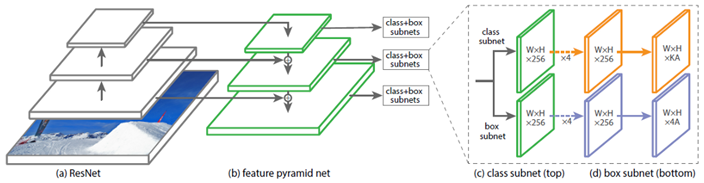

## Backbone часть сети RetinaNet

Учитывая, что часть архитектуры RetinaNet, которая принимает на вход изображение и выделяет важные признаки, является вариативной и извлеченная из этой части информация будет обрабатываться на следующих этапах, то важно выбрать подходящую backbone-сеть для лучших результатов.

Недавние исследования по оптимизации СНС позволили разработать классификационные модели, которые опередили все ранее разработанные архитектуры с лучшими показателями точности на датасете ImageNet при улучшении эффективности в 10 раз. Данные сети получили название EfficientNet-B(0-7). Показатели семейства новых сетей представлены на рисунке ниже

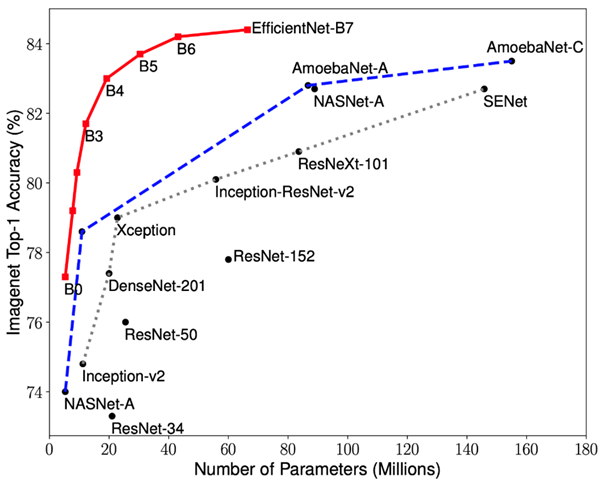

## Пирамида признаков

Feature Pyramid Network состоит из трёх основных частей: восходящий путь (bottom-up pathway), нисходящий путь (top-down pathway) и боковые соединения (lateral connections).
Восходящий путь представляет собой некую иерархическую «пирамиду» – последовательность свёрточных слоёв с уменьшающейся размерностью, в нашем случае – backbone сеть. Верхние слои сверточной сети имеют большее семантическое значение, но меньшее разрешение, а нижние наоборот. Bottom-up pathway имеет уязвимость при извлечении признаков – потеря важной информации об объекте, например из-за зашумления небольшого, но значимого, объекта фоном, так как к концу сети информация сильно сжата и обобщена.


Нисходящий путь также представляет собой «пирамиду». Карты признаков верхнего слоя этой пирамиды имеют размер карт признаков верхнего слоя bottom-up пирамиды и увеличиваются вдвое методом ближайшего соседа (рисунок ниже) по направлению вниз.

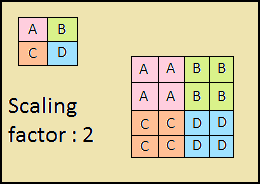

Таким образом в top-down сети каждая карта признаков вышележащего слоя увеличивается до размеров карты нижележащего. Помимо этого, в FPN присутствуют боковые соединения, это означает, что карты признаков соответствующих слоёв bottom-up и top-down пирамид поэлементно складываются, причём карты из bottom-up проходят свёртку 1*1. Этот процесс схематично представлен на следующем рисунке.


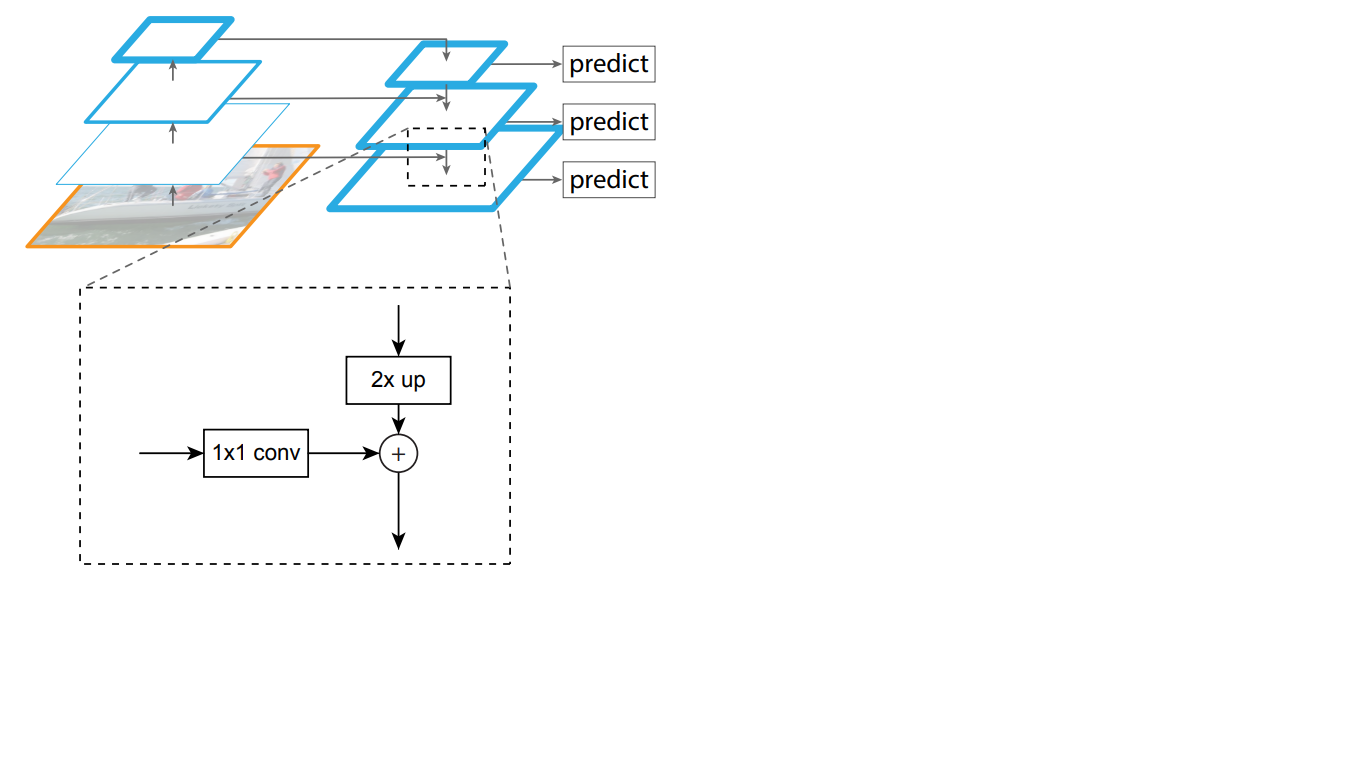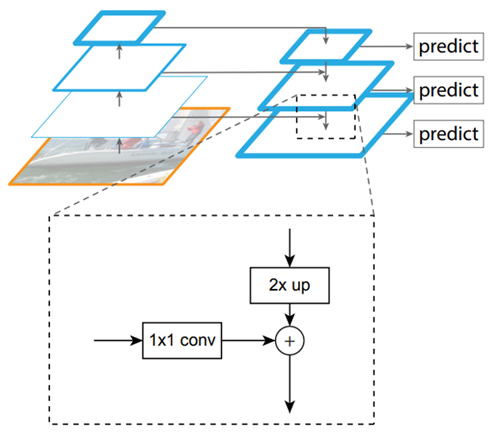

Боковые соединения решают проблему затухания важных сигналов в процессе прохода по слоям, совмещая семантически важную информацию, полученную к концу первой пирамиды и более детальную информацию, полученную в ней ранее.

Далее, каждый из полученных слоёв в top-down пирамиде обрабатывается двумя подсетями.

## Подсети классификации и регреcсии

Третьей частью архитектуры RetinaNet являются две подсети: классификационная и регрессионная. Каждая из этих подсетей образует на выходе ответ о классе объекта и его расположении на изображении. Рассмотрим принцип работы каждой из них.

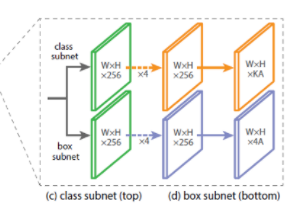

Разница в принципах работы рассматриваемых блоков (подсетей) не отличается до последнего слоя. Каждый из них состоит из 4 слоёв свёрточных сетей. В слое формируются 256 карт признаков. На пятом слое количество карт признаков изменяется: регрессионная подсеть имеет 4*A карт признаков, классификационная – K*A карт признаков, где A – количество якорных рамок (подробное описание якорных рамок в следующем подразделе), K – количество классов объектов.

В последнем, шестом, слое каждая карта признаков преобразуется в набор векторов. Регрессионная модель на выходе имеет для каждой якорной рамки вектор из 4 значений, указывающих смещение целевой рамки (англ. ground-truth box) относительно якорной. Классификационная модель имеет на выходе для каждой якорной рамки one-hot вектор длиной K, в котором индекс со значением 1 соответствует номеру класса, который нейросеть присвоила объекту.

## Якорные рамки

В прошлом разделе был использован термин якорных рамок. Якорная рамка (англ. anchor box) – гиперпараметр нейросетей-детекторов, заранее определенный ограничивающий прямоугольник, относительно которого работает сеть.

Допустим, сеть имеет на выходе карту признаков размером 3*3. В RetinaNet каждая из ячеек имеет 9 якорных рамок, каждая из которых имеет разный размер и соотношение сторон. Во время обучения каждой целевой рамке подбираются в соответствие якорные рамки. Если их показатель IoU имеет значение от 0.5, то якорная рамка назначается целевой, если значение меньше 0.4, то она считается фоном, в других случаях якорная рамка будет проигнорирована для обучения. Классификационная сеть обучается относительно выполненного назначения (класс объекта или фон), регрессионная сеть обучается относительно координат якорной рамки (важно отметить, что ошибка вычисляется относительно якорной, но не целевой рамки).

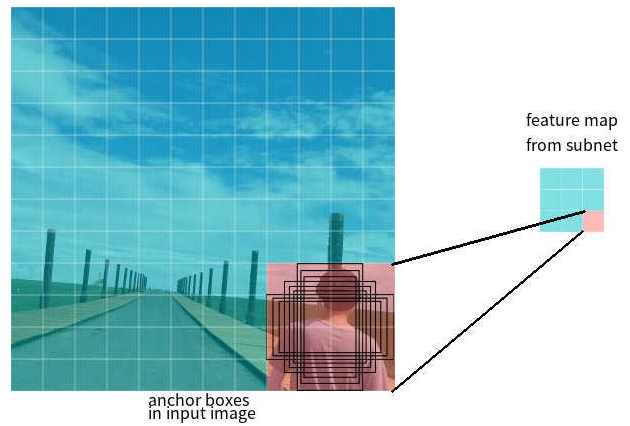

## Функции потерь

Потери RetinaNet являются составными, их составляют два значения: ошибка регрессии, или локализации (ниже обозначено как Lloc), и ошибка классификации (ниже обозначено как Lcls). Общая функция потерь может быть записана как:


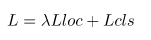


Где λ является гиперпараметром, который контролирует баланс между двумя потерями.

Рассмотрим подробнее вычисление каждой из потерь.
Как было описано ранее, каждой целевой рамке назначается якорная. Обозначим эти пары как (Ai,Gi)i=1,...N, где А представляет якорь, G – целевую рамку, а N количество сопоставленных пар.

Для каждого якоря регрессионная сеть предсказывает 4 числа, которые можно обозначить как Pi=(Pix,Piy,Piw,Pih). Первые две пары означают предсказанную разницу между координатами центров якорной Ai и целевой рамки Gi, а последние две – предсказанную разницу между их шириной и высотой. Соответственно, для каждой целевой рамки вычисляется Ti, как разница между якорной и целевой рамкой:

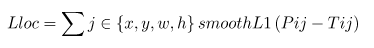


Где smoothL1(х) определяется формулой ниже:


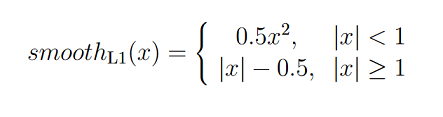


Потери задачи классификации в сети RetinaNet вычисляются с помощью функции Focal loss.


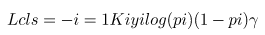


где К – количество классов, уi – целевое значение класса, р – вероятность предсказания i-го класса, γ – параметр фокуса, α – коэффициент смещения. Данная функция является усовершенствованной функцией кросс-энтропии. Отличие заключается в добавлении параметра γ∈(0,+∞), который решает проблему несбалансированности классов. Во время обучения, большая часть объектов, обрабатываемых классификатором, является фоном, который является отдельным классом. Поэтому может возникнуть проблема, когда нейросеть обучится определять фон лучше, чем другие объекты. Добавление нового параметра решило данную проблему, уменьшив значение ошибки для легко классифицируемых объектов. Графики функций focal и cross entropy представлены на рисунке ниже.


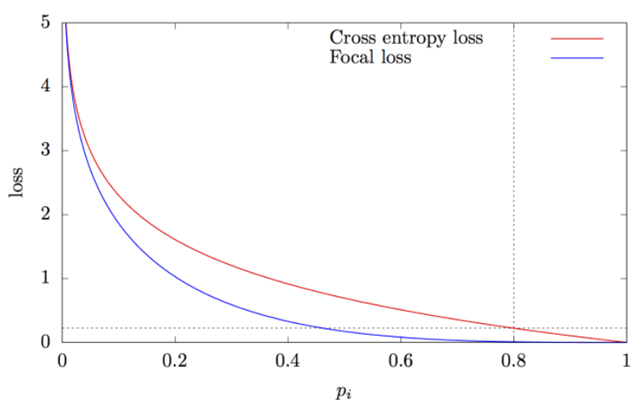

# Подготовка к работе и реализация вспомогательных функций

## Импорты библиотек

In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Скачаем набор данных COCO2017
Обучение всему набору данных COCO2017, содержащему около 118 тыс. изображений, занимает много времени, поэтому в этом примере для обучения мы будем использовать меньшее подмножество из примерно 500 изображений.

In [2]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")

560525318/560525318 [==============================] - 20s 0us/step


## Реализация служебных функций

Ограничивающие рамки или боксы (bounding boxes) могут быть представлены несколькими способами, наиболее распространенными являются следующие форматы:

- Хранение координат углов `[xmin, ymin, xmax, ymax]`
- Запоминание координат центра и размеров бокса
`[х, у, ширина, высота]`

Поскольку нам нужны оба формата, мы будем реализовывать функции для преобразования между форматами.

In [3]:
def swap_xy(boxes):
    """Меняет порядок координат x и y ограничивающих рамок (bounding boxes).
     Аргументы:
       boxes: тензор с формой `(num_boxes, 4)`, представляющий ограничивающие рамки.
     Возвращает:
       поменянные местами боксы с формой такой же, как у исходных боксов.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """
    Изменяет формат боксов на центр, ширину и высоту.

    Аргументы:
      boxes: тензор 2-го ранга или выше в форме `(..., num_boxes, 4)`,
        представляющие боксы, где каждый бокс имеет формат
        `[xmin, ymin, xmax, ymax]`.

    Возвращает:
      преобразованные боксы с формой, такой же, как у исходных боксов.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """
    Изменяет формат боксов на координаты углов.

    Аргументы:
      boxes: тензор 2-го ранга или выше в форме `(..., num_boxes, 4)`,
        представляющие боксы, где каждый бокс имеет формат
        `[х, у, ширина, высота]`.

    Возвращает:
      преобразованные боксы с формой, такой же, как у исходных боксов.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

## Вычисление IOU
Как мы увидим позже в этом примере, мы будем классифицировать тип боксов в зависимости от степени перекрытия боксов. Это потребует от нас вычисления Intersection Over Union (IOU) между всеми парами anchor boxes и целевых боксов (ground truth boxes).

In [4]:
def compute_iou(boxes1, boxes2):
    """
    Вычисляет попарную матрицу IOU для заданных двух наборов боксов.

    Аргументы:
      boxes1: тензор формы `(N, 4)`, представляющий боксы,
        где каждое поле имеет формат `[x, y, ширина, высота]`.
      boxes2: тензор формы `(M, 4)`, представляющий боксы,
        где каждое поле имеет формат `[x, y, ширина, высота]`.

    Возвращает:
      попарная матрица IOU формы `(N, M)`, где значение в i-й строке
        j-й столбец содержит значение IOU между i-м боксом и j-м боксом.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Визуализация обнаружения"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


## Реализация генератора anchor boxes
Боксы привязки (anchor boxes) — это боксы фиксированного размера, которые модель использует для прогнозирования ограничивающей рамки объекта. Она делает это путем регрессии смещения между положением центра объекта и центром поля привязки, а затем использует ширину и высоту поля привязки для прогнозирования относительного масштаба объекта. В случае RetinaNet каждое местоположение на заданной карте объектов имеет девять якорных полей (в трех масштабах и трех соотношениях).

In [5]:
class AnchorBox:
    """
    Генерирует якорные боксы.

    Этот класс имеет операции для создания блоков привязки для карт объектов со смещениями `[8, 16, 32, 64, 128]`. 
    Каждый бокс сохраняется в формате `[x, y, ширина, высота]`.

    Атрибуты:
      aspect_ratios: список значений с плавающей точкой, представляющих соотношение сторон
        якорных боксов в каждом месте на карте объектов,
      scales: список значений с плавающей точкой, представляющих масштаб полей привязки
        в каждом месте на карте объектов,
      num_anchors: количество якорных боксов в каждом месте на карте объектов,
      areas: список значений площадей якорных боксов,
      strides: список значений свдигов ядра свертки.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """
        Вычисляет размерности якорных боксов для всех соотношений и масштабов на всех уровнях пирамиды признаков.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """
        Создает якорные объекты для заданных размеров и уровня карты объектов.

        Аргументы:
          feature_height: целое число, представляющее высоту карты объектов,
          feature_width: целое число, представляющее ширину карты объектов,
          level: целое число, представляющее уровень карты объектов в пирамиде.
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """
        Создает якорные боксы для всех карт объектов пирамиды.

        Аргументы:
          image_height: высота входного изображения,
          image_width: ширина входного изображения.

        Возвращает:
          якорные боксы для всех карт объектов, сложенные в виде единого тензора
          с формой `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

## Предобработка данных

Предварительная обработка изображений включает два этапа:

- Изменение размера изображения: изображения изменяются таким образом, чтобы меньшая сторона ограничивалась 800 пикселями, после изменения размера, если большая сторона изображения превышает 1333 пикселей, размер изображения изменяется таким образом, что большая сторона ограничивается 1333 пикселями.
- Изменение масштаба: случайное изменение масштаба и случайное горизонтальное переворачивание.

Наряду с изображениями ограничивающие рамки масштабируются и при необходимости переворачиваются.

In [6]:
def random_flip_horizontal(image, boxes):
    """
    Переворачивает изображение и боксы по горизонтали с вероятностью 50%.

    Аргументы:
      image: трехмерный тензор формы `(высота, ширина, каналы)`, представляющий изображение,
      boxes: тензор с формой `(num_boxes, 4)`, представляющий ограничивающие рамки,
        имеющие нормированные координаты.

    Возвращает:
      Случайно перевернутое изображение и боксы.
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """
    Изменяет размеры и дополняет изображение, сохраняя соотношение сторон.

    Аргументы:
      image: трехмерный тензор формы `(высота, ширина, каналы)`, представляющий изображение,
      min_side: размер более короткой стороны изображения изменяется до этого значения, если
        jitter установлено на False,
      max_side: если более длинная сторона изображения превышает это значение после
        изменения размера, размер изображения изменяется таким образом, что длинная сторона 
        имела это значение,
      jitter: список вещественных чисел, содержащий минимальный и максимальный размер для изменения масштаба,
      stride: сдвиг ядра свертки для карты объектов в пирамиде, 
        можно рассчитать с помощью `image_size/feature_map_size`.

    Возвращает:
      image: измененное изображение,
      image_shape: исходный размер изображения,
      ratio: коэффициент масштабирования, используемый для изменения размера изображения.
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    """
    Применяет этап предварительной обработки к одному объекту.

    Аргументы:
      sample: словарь, представляющий один обучающий объект.

    Возвращает:
      image: изображение с измененными размером и примененным случайным горизонтальным отражением,
      bbox: ограничивающие рамки формы `(num_objects, 4)`, 
        где каждая рамка имеет формат `[x, y, ширина, высота]`,
      class_id: тензор, представляющий метки классов объектов, имеющий форму `(num_objects,)`.

    """
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## Разметка

Необработанная разметка, состоящая из ограничивающих рамок и меток классов, должна быть преобразована перед обучением. Это преобразование состоит из
следующих шагов:

- Генерация якорных боксов для заданных размеров изображения
- Назначение истинных боксов (из разметки) якорным боксам
- Якорные боксы, которым не принадлежат какие-либо объекты, либо относятся к фоновыму класс или игнорируются в зависимости от IOU
- Генерация целевых переменных для задач классификации и регрессии с использованием якорных боксов

In [7]:
class LabelEncoder:
    """
    Преобразует необработанную разметку к необходимому формату.

    Атрибуты:
      anchor_box: генератор якорных боксов для кодирования ограничивающих рамок,
      box_variance: коэффициенты масштабирования, используемые для масштабирования якорных боксов.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """
        Сопоставляет истинные боксы с якорными боксами на основе значений IOU.

        1. Вычисляет парные IOU для M `anchor_boxes` и N `gt_boxes`,
          чтобы получить матрицу в форме `(M, N)`.
        2. Истинный бокс с максимальным IOU в строке присваивается тому якорному боксу, 
          значение IOU с которым больше чем `match_iou`.
        3. Если максимальное IOU в строке меньше, чем `ignore_iou`, якорный бокс относится к фоновому.
        4. Остальные якорные боксы, которым не назначен какой-либо класс,
          игнорируются во время обучения.

        Аргументы:
          anchor_boxes: тензор с вещественными числами `(total_anchors, 4)`,
            представляющий все якорные боксы для заданной формы входного изображения,
            где каждый якорный бокс имеет формат `[x, y, ширина, высота]`,
          gt_boxes: тензор с вещественными числами `(num_objects, 4)`, представляющий
            все истинные боксы, где каждый блок имеет формат
            `[х, у, ширина, высота]`,
          match_iou: вещественное значение, представляющее минимальный порог IOU для
            определения того, может ли истинный блок быть назначен якорному боксу,
          ignore_iou: вещественное значение, представляющее порог IOU, ниже которого
            якорный бокс относится к фоновому классу.

        Возвращает:
          matched_gt_idx: индекс совпавшего объекта,
          positive_mask: маска для якорных блоков, которым назначены инстинные боксы,
          ignore_mask: маска якорных боксов, которые необходимо игнорировать во время обучения.
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Преобразует истинные боксы к необходимому формату."""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """
        Создает боксы и метки классов для одного объекта.
        """
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """
        Создает боксы и метки классов для батча.
        """
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


# Построение архитектуры модели

## Построение магистрали ResNet50
RetinaNet использует в качестве основы модель ResNet. В этом примере мы используем ResNet50 в качестве основы и возвращаем карты признаков со сдвигами 8, 16 и 32.

In [8]:
def get_backbone():
    """Создает ResNet50 с предварительно обученными весами imagenet."""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

## Построение пирамидальной сети объектов в качестве пользовательского слоя

In [9]:
class FeaturePyramid(keras.layers.Layer):
    """Строит пирамиду признаков с весами из модели-основы.

     Атрибуты:
       num_classes: количество классов в наборе данных,
       backbone: основа для построения пирамиды признаков.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


## Построение целевых переменных для задач классификации и регрессии
Модель RetinaNet имеет отдельные "головы" для регрессии размеров ограничивающей рамки и для прогнозирования вероятностей классов для объектов. Эти головы являются общими для всех карт признаков.

In [10]:
def build_head(output_filters, bias_init):
    """
    Создает "головы" для предсказания класса\бокса.

     Аргументы:
       output_filters: количество сверточных фильтров в последнем слое,
       bias_init: инициализатор смещения для последнего сверточного слоя.

     Возвращает:
       Модель keras, для классификации или регрессии
       в зависимости от `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

## Создание RetinaNet

In [11]:
class RetinaNet(keras.Model):
    """
    Подкласс модели Keras, реализующий архитектуру RetinaNet.

    Атрибуты:
      num_classes: количество классов в наборе данных,
      backbone: основа для построения пирамиды функций.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


## Реализация пользовательского слоя для декодирования прогнозов

In [12]:
class DecodePredictions(tf.keras.layers.Layer):
    """
    Слой Keras, который декодирует прогнозы модели RetinaNet.

    Атрибуты:
      num_classes: количество классов в наборе данных,
      trust_threshold: минимальная вероятность класса, ниже которой обнаружения игнорируются,
      nms_iou_threshold: порог IOU для операции NMS,
      max_detections_per_class: максимальное количество обнаружений, 
      которые необходимо сохранить для одного класса,
      max_detections: максимальное количество всех обнаружений,
      box_variance: коэффициенты масштабирования, используемые для масштабирования ограничивающей рамки.
    """

    def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

## Реализация функций потерь

In [13]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Обертка для объединения обеих функций потерь"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


## Настройка параметров тренировки

In [14]:
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

## Инициализация и компиляция модели

In [15]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

94765736/94765736 [==============================] - 5s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Настройка обратных вызовов

In [16]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

## Загрузка набора данных COCO2017

In [17]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

## Настройка `tf.data`

Чтобы обеспечить эффективную подачу данных в модель, мы будем использовать
`tf.data` API для создания потока входных данных. Он состоит из следующих основных этапов обработки:

- Применение функции предварительной обработки к образцам
- Создание батчей с фиксированным размером (поскольку изображения в батче могут
иметь разные размеры, а также могут иметь разное количество объектов, мы используем `padded_batch`, чтобы добавить необходимые отступы для создания прямоугольных тензоров)
- Создание целевых переменных для каждого образца в батче и использованием `LabelEncoder`

In [18]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


## Обучение модели

In [19]:
# Для обучения на всем наборе данных раскомментируйте строки ниже

# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

# Обчение на 100 обучающих и 50 валидационных объектах,
# удалите `.take` при обучении на всем наборе данных

model.fit(
    train_dataset.take(100),
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

    100/Unknown - 331s 3s/step - loss: 4.0768

KeyboardInterrupt: ignored

## Загрузка весов

In [ ]:
weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

## Построение модели для инференса

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

## Проверка модели

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )